# Testing



In [1]:
import pandas as pd
import numpy as np
import math
from bson import ObjectId
from pymongo import MongoClient


import re
import os

import json

client = MongoClient()


In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ordovas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Now we load the dataset and examine how it is loaded.

In [3]:
db = client.get_database("amazon")
# Define an alias for the books dataset
books =db.books
# Obtain a random sample from the dataset
res = list(books.aggregate([
    { "$sample": { "size": 50000 } }
]))
# Converting to pandas DataFrame
df=pd.DataFrame(res)

In [4]:
df.head()

,_id,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,6033ab8df7ccad4a92f71753,5,True,"08 15, 2016",ADGHSVTS66908,0007546394,{'Format:': ' Kindle Edition'},Marilyn Huff,Agatha Christie is the queen of crime.,Great read,1471219200,NaN,NaN
1,6033ab73f7ccad4a92f1cb9a,5,True,"03 11, 2015",ARTNPLHDVHYHG,0002171856,{'Format:': ' Paperback'},ian,"A must have, very informative",Great tool to have,1426032000,NaN,NaN
2,6033ab89f7ccad4a92f62fa4,5,False,"12 4, 2013",A33JXFXAAV5018,0007444117,{'Format:': ' Kindle Edition'},MC,Wow! I'm usually pretty good at figuring out ...,What a page turner!,1386115200,NaN,NaN
3,6033ab99f7ccad4a92f963ee,5,True,"10 28, 2017",A369K513GP75BB,0060091290,{'Format:': ' Hardcover'},shopper J,the book was very light and funny,Five Stars,1509148800,NaN,NaN
4,6033ab7af7ccad4a92f33765,5,True,"04 26, 2014",AX5YM0DO4GGP3,0007131925,{'Format:': ' Hardcover'},Heidi,"Great book on health, bettering yourself and y...",Great book!,1398470400,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   _id             50000 non-null  object
 1   overall         50000 non-null  int64 
 2   verified        50000 non-null  bool  
 3   reviewTime      50000 non-null  object
 4   reviewerID      50000 non-null  object
 5   asin            50000 non-null  object
 6   style           47610 non-null  object
 7   reviewerName    49999 non-null  object
 8   reviewText      49992 non-null  object
 9   summary         49993 non-null  object
 10  unixReviewTime  50000 non-null  int64 
 11  vote            9325 non-null   object
 12  image           69 non-null     object
dtypes: bool(1), int64(2), object(10)
memory usage: 4.6+ MB


In [6]:
df=df.dropna(subset=['reviewText', 'reviewerName',"summary"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49984 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   _id             49984 non-null  object
 1   overall         49984 non-null  int64 
 2   verified        49984 non-null  bool  
 3   reviewTime      49984 non-null  object
 4   reviewerID      49984 non-null  object
 5   asin            49984 non-null  object
 6   style           47596 non-null  object
 7   reviewerName    49984 non-null  object
 8   reviewText      49984 non-null  object
 9   summary         49984 non-null  object
 10  unixReviewTime  49984 non-null  int64 
 11  vote            9324 non-null   object
 12  image           69 non-null     object
dtypes: bool(1), int64(2), object(10)
memory usage: 5.0+ MB


In [8]:
df["vote"]=df["vote"].fillna(value=0)
df["vote"]=df["vote"].apply(lambda x: int(str(x).replace(",","")))


In [9]:
len(df[df["vote"]>1]["vote"]),len(df[df["vote"]<1]["vote"])

(9324, 40660)

In [10]:
def cleaning_review(texts):
    #Remove numbers, punctuation and lowercase everything
    res=re.sub("[^A-Za-z]+", " ", texts.lower()) 
    #Remove words with less than 4 letters
    res=re.sub(r'\b\w{1,3}\b', "", res) 
    #Remove rest of stop words
    for stopword in stopwords.words('english'): 
        sw=stopword.replace("'","")
        res=res.replace(f" {sw} "," ")
    return res

df["review_clean"]=df["reviewText"]
df["review_clean"]=df["review_clean"].apply(cleaning_review)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
#dff=df.sample(frac=0.1, replace=True, random_state=1)
df=df.reset_index()


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(min_df=3)
x = v.fit_transform(df['review_clean']).toarray()

In [14]:
df_tfidf = pd.DataFrame(x, columns=v.get_feature_names())

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_tfidf, df["overall"], test_size=0.15, random_state=42)

In [16]:
len(y_train),len(y_test)

(42486, 7498)

In [17]:
len(df_tfidf.columns)

27573

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
clf = LogisticRegression(random_state=0,class_weight="balanced").fit(X_train, y_train)


/home/ordovas/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
y_pred=clf.predict(X_train)

In [21]:
import matplotlib.pyplot as plt

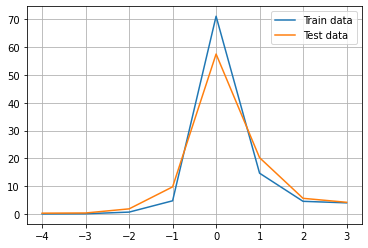

In [22]:
#plt.hist(y_train-clf.predict(X_train),bins=np.arange(-4,5),align="left",weights=counts);
counts, bins = np.histogram(y_train-clf.predict(X_train),bins=np.arange(-4,5))
plt.plot(bins[:-1],counts*100/sum(counts),label="Train data")
plt.grid()
counts, bins = np.histogram(y_test-clf.predict(X_test),bins=np.arange(-4,5))
plt.plot(bins[:-1],counts*100/sum(counts),label="Test data")
plt.legend();

In [23]:
clf.score(X_train, y_train)

0.7109165372122581

In [24]:
clf.score(X_test, y_test)

0.5750866897839424

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
confusion_matrix(y_train,clf.predict(X_train))

array([[ 1383,    22,    20,    10,    21],
       [   52,  1669,    41,    19,    35],
       [  170,   279,  2818,   329,   259],
       [  236,   332,   969,  5461,  1633],
       [  755,   720,  1442,  4938, 18873]])

In [27]:
confusion_matrix(y_test,clf.predict(X_test))

array([[ 122,   67,   36,    9,   24],
       [  91,   99,   69,   25,   20],
       [  67,  124,  255,  182,   79],
       [  52,   75,  291,  636,  415],
       [ 124,  141,  282, 1013, 3200]])

In [28]:
clf.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}